# Machine Learning Solution

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import BooleanType, DateType, FloatType, IntegerType, LongType

In [2]:
# Spark Session
spark = SparkSession.builder.appName('Fraud-Detector').getOrCreate()

22/01/25 19:14:11 WARN Utils: Your hostname, francesc-Inspiron-5570 resolves to a loopback address: 127.0.1.1; using 192.168.1.141 instead (on interface wlp3s0)
22/01/25 19:14:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/25 19:14:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Read datasets
df_train = spark.read.csv('data/clean_fraudTrain.csv', header=True)
df_test = spark.read.csv('data/clean_fraudTest.csv', header=True)

In [4]:
# Show Pretty Data
df_train.limit(5).toPandas()

,credit_card_num,shop,category,amount,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,age
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,31
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,41
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.262,4154,Nature conservation officer,43.150704,-112.154481,0,57
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0,M,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0,52
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0,33


In [5]:
# Cast Data
df_train.printSchema()

root
 |-- credit_card_num: string (nullable = true)
 |-- shop: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- age: string (nullable = true)



**We have to cast all the data because the csv, don't have meta-data that indicates the type.**

In [6]:
def cast_df(df):
    df = df.withColumn("credit_card_num", df.credit_card_num.cast(LongType()))
    df = df.withColumn("amount", df.amount.cast(FloatType()))
    df = df.withColumn("lat", df.lat.cast(FloatType()))
    df = df.withColumn("long", df.long.cast(FloatType()))
    df = df.withColumn("city_pop", df.city_pop.cast(IntegerType()))
    df = df.withColumn("merch_lat", df.merch_lat.cast(FloatType()))
    df = df.withColumn("merch_long", df.merch_long.cast(FloatType()))
    df = df.withColumn("is_fraud", df.is_fraud.cast(IntegerType()))
    df = df.withColumn("age", df.age.cast(IntegerType()))
    return df

In [7]:
# Cast
df_train = cast_df(df_train)
df_test = cast_df(df_test)

In [8]:
# Encode Categorical Variables
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline

cat_col = ['shop', 'category', 'gender', 'job']

list_string_indexer = [StringIndexer(inputCol=c, outputCol=c + "_indexed") for c in cat_col]
ppl = Pipeline(stages=list_string_indexer)

df_train_indexed = ppl.fit(df_train).transform(df_train).drop(*cat_col)
df_test_indexed = ppl.fit(df_test).transform(df_test).drop(*cat_col)

**We have to encode string variables to int, because the algorithm/s that we will use don't support strings.** 

In [9]:
df_train_indexed.limit(5).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed
0,2703186189652095,4.970000,36.078800,-81.178101,3495,36.011292,-82.048317,0,31,571.0,11.0,0.0,141.0
1,630423337322,107.230003,48.887798,-118.210503,149,49.159046,-118.186462,0,41,81.0,1.0,0.0,61.0
2,38859492057661,220.110001,42.180801,-112.262001,4154,43.150703,-112.154480,0,57,319.0,6.0,1.0,457.0
3,3534093764340240,45.000000,46.230598,-112.113800,1939,47.034332,-112.561073,0,52,40.0,0.0,1.0,232.0
4,375534208663984,41.959999,38.420700,-79.462898,99,38.674999,-78.632462,0,33,519.0,10.0,1.0,297.0


In [10]:
from pyspark.ml.feature import VectorAssembler

numericCols = ['credit_card_num', 'amount', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age',
               'gender_indexed', 'category_indexed', 'shop_indexed', 'job_indexed']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

df_train_indexed = assembler.transform(df_train_indexed)
df_test_indexed = assembler.transform(df_test_indexed)

In [11]:
df_test_indexed.limit(5).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed,features
0,2291163933867244,2.860000,33.965900,-80.935501,333497,33.986389,-81.200714,0,52,469.0,7.0,1.0,40.0,"[2291163933867244.0, 2.859999895095825, 33.965..."
1,3573030041201292,29.840000,40.320702,-110.435997,302,39.450497,-109.960434,0,30,386.0,7.0,0.0,33.0,"[3573030041201292.0, 29.84000015258789, 40.320..."
2,3598215285024754,41.279999,40.672901,-73.536499,34496,40.495811,-74.196114,0,50,440.0,9.0,0.0,28.0,"[3598215285024754.0, 41.279998779296875, 40.67..."
3,3591919803438423,60.049999,28.569700,-80.819099,54767,28.812399,-80.883064,0,33,500.0,10.0,1.0,328.0,"[3591919803438423.0, 60.04999923706055, 28.569..."
4,3526826139003047,3.190000,44.252899,-85.016998,1126,44.959148,-85.884735,0,65,641.0,13.0,1.0,258.0,"[3526826139003047.0, 3.190000057220459, 44.252..."


In [12]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="is_fraud", featuresCol="features", numTrees=5,maxBins=693)
model = rf.fit(df_train_indexed)

In [13]:
# Make Predictions
predictions = model.transform(df_test_indexed)

In [14]:
predictions.limit(10).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed,features,rawPrediction,probability,prediction
0,2291163933867244,2.860000,33.965900,-80.935501,333497,33.986389,-81.200714,0,52,469.0,7.0,1.0,40.0,"[2291163933867244.0, 2.859999895095825, 33.965...","[4.988965767697938, 0.011034232302061159]","[0.9977931535395876, 0.002206846460412232]",0.0
1,3573030041201292,29.840000,40.320702,-110.435997,302,39.450497,-109.960434,0,30,386.0,7.0,0.0,33.0,"[3573030041201292.0, 29.84000015258789, 40.320...","[4.988965767697938, 0.011034232302061159]","[0.9977931535395876, 0.002206846460412232]",0.0
2,3598215285024754,41.279999,40.672901,-73.536499,34496,40.495811,-74.196114,0,50,440.0,9.0,0.0,28.0,"[3598215285024754.0, 41.279998779296875, 40.67...","[4.988965767697938, 0.011034232302061159]","[0.9977931535395876, 0.002206846460412232]",0.0
3,3591919803438423,60.049999,28.569700,-80.819099,54767,28.812399,-80.883064,0,33,500.0,10.0,1.0,328.0,"[3591919803438423.0, 60.04999923706055, 28.569...","[4.990094156098026, 0.009905843901973294]","[0.9980188312196054, 0.001981168780394659]",0.0
4,3526826139003047,3.190000,44.252899,-85.016998,1126,44.959148,-85.884735,0,65,641.0,13.0,1.0,258.0,"[3526826139003047.0, 3.190000057220459, 44.252...","[4.988965767697938, 0.011034232302061159]","[0.9977931535395876, 0.002206846460412232]",0.0
5,30407675418785,19.549999,42.193901,-76.736099,520,41.747158,-77.584198,0,29,214.0,4.0,0.0,275.0,"[30407675418785.0, 19.549999237060547, 42.1939...","[4.988965767697938, 0.011034232302061159]","[0.9977931535395876, 0.002206846460412232]",0.0
6,213180742685905,133.929993,40.507000,-123.974297,1139,41.499458,-124.888725,0,69,494.0,9.0,0.0,68.0,"[213180742685905.0, 133.92999267578125, 40.506...","[4.988965767697938, 0.011034232302061159]","[0.9977931535395876, 0.002206846460412232]",0.0
7,3589289942931264,10.370000,43.755699,-97.593597,343,44.495499,-97.728455,0,48,379.0,7.0,0.0,154.0,"[3589289942931264.0, 10.369999885559082, 43.75...","[4.988965767697938, 0.011034232302061159]","[0.9977931535395876, 0.002206846460412232]",0.0
8,3596357274378601,4.370000,41.000099,-78.235703,3688,41.546066,-78.120239,0,47,237.0,3.0,1.0,232.0,"[3596357274378601.0, 4.369999885559082, 41.000...","[4.988965767697938, 0.011034232302061159]","[0.9977931535395876, 0.002206846460412232]",0.0
9,3546897637165774,66.540001,31.659100,-96.809402,263,31.782919,-96.366188,0,64,422.0,8.0,0.0,23.0,"[3546897637165774.0, 66.54000091552734, 31.659...","[4.988965767697938, 0.011034232302061159]","[0.9977931535395876, 0.002206846460412232]",0.0


# Metrics and evaluation

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9959475922183694
Test Error = 0.004052407781630629


In [16]:
# Metrics
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.MulticlassMetrics.html

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = predictions.select(['prediction', 'is_fraud']).withColumn('is_fraud', F.col('is_fraud').cast(
    FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction', 'is_fraud'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))


In [17]:
# Confusion Matrix
conf_matrix = metrics.confusionMatrix().toArray()

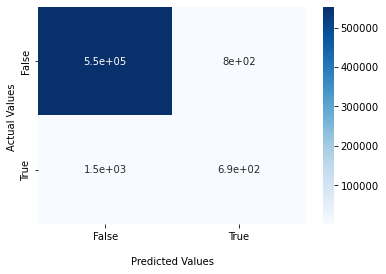

In [18]:
import seaborn as sns

ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [19]:
# Decode Labels
list_index_string = [IndexToString(inputCol=c + "_indexed", outputCol=c) for c in cat_col]
ppl = Pipeline(stages=list_index_string)

df_train_decoded = ppl.fit(df_train_indexed).transform(df_train_indexed).drop(
    *['shop_indexed', 'gender_indexed', 'job_indexed', 'features'])
df_test_decoded = ppl.fit(predictions).transform(predictions).drop(
    *['shop_indexed', 'gender_indexed', 'job_indexed', 'features', 'rawPrediction', 'probability'])

In [20]:
df_test_decoded.filter(df_test_decoded.is_fraud != df_test_decoded.prediction).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,6011109736646996,1199.449951,34.265099,-77.866997,186140,34.622776,-77.827866,0,37,5.0,1.0,fraud_Schumm PLC,shopping_net,F,English as a second language teacher
1,38530489946071,1881.530029,34.957199,-81.991600,530,34.709045,-82.585106,0,31,3.0,1.0,fraud_Metz-Boehm,shopping_pos,F,Animal technologist
2,3518234918950662,724.140015,33.637199,-96.618401,46563,34.496590,-96.913338,0,50,5.0,1.0,"fraud_Gottlieb, Considine and Schultz",shopping_net,F,Systems developer
3,4302480582202074,981.919983,43.232601,-86.249199,128715,43.849102,-85.560455,0,25,5.0,1.0,"fraud_Towne, Greenholt and Koepp",shopping_net,M,Historic buildings inspector/conservation officer
4,4956828990005111019,1420.900024,40.674702,-74.223900,124967,41.030464,-74.717384,0,40,5.0,1.0,fraud_Kassulke PLC,shopping_net,M,Operational researcher
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,30551643947183,857.280029,35.183601,-81.455200,5621,34.244728,-81.640610,0,47,5.0,1.0,fraud_Fisher Inc,shopping_net,F,Toxicologist
2248,3536818734263520,1540.150024,41.603001,-93.633003,222785,40.875282,-93.640648,0,39,5.0,1.0,"fraud_Heathcote, Yost and Kertzmann",shopping_net,M,Interior and spatial designer
2249,4755696071492,275.470001,32.964298,-96.601196,20328,32.064377,-97.526024,0,36,2.0,1.0,fraud_White and Sons,home,M,Site engineer
2250,630451534402,850.869995,46.353500,-86.634499,765,45.905235,-86.690140,0,49,5.0,1.0,fraud_Gleason-Macejkovic,shopping_net,F,Immunologist


In [21]:
df_test_decoded.filter(df_test_decoded.is_fraud == 1).filter(df_test_decoded.prediction == 0).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,3560725013359375,24.840000,31.859900,-102.741302,23,32.575874,-102.604286,1,51,9.0,0.0,fraud_Hamill-D'Amore,health_fitness,F,Cytogeneticist
1,6564459919350820,780.520020,42.554501,-90.350800,1306,42.461128,-91.147148,1,62,11.0,0.0,"fraud_Rodriguez, Yost and Jenkins",misc_net,M,Public relations officer
2,6564459919350820,620.330017,42.554501,-90.350800,1306,42.771835,-90.158363,1,62,6.0,0.0,fraud_Nienow PLC,entertainment,M,Public relations officer
3,3560725013359375,842.650024,31.859900,-102.741302,23,31.315783,-102.736389,1,51,3.0,0.0,fraud_Hermann and Sons,shopping_pos,F,Cytogeneticist
4,3524574586339330,22.549999,27.632999,-80.403099,105638,28.396402,-80.819466,1,34,9.0,0.0,fraud_Thompson-Gleason,health_fitness,F,"Librarian, public"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,4716561796955522,219.110001,48.277699,-112.845596,743,47.911221,-113.691605,1,49,2.0,0.0,fraud_Botsford and Sons,home,F,Water engineer
1452,2242176657877538,6.600000,34.632301,-89.885498,14462,34.610104,-89.275887,1,62,0.0,0.0,fraud_Mraz-Herzog,gas_transport,M,Database administrator
1453,2242176657877538,1041.510010,34.632301,-89.885498,14462,34.573471,-89.911011,1,62,3.0,0.0,"fraud_Willms, Kris and Bergnaum",shopping_pos,M,Database administrator
1454,2242176657877538,868.090027,34.632301,-89.885498,14462,34.091228,-90.390610,1,62,3.0,0.0,fraud_Kuhn LLC,shopping_pos,M,Database administrator


In [22]:
df_test_decoded.filter(df_test_decoded.is_fraud == 0).filter(df_test_decoded.prediction == 1).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,6011109736646996,1199.449951,34.265099,-77.866997,186140,34.622776,-77.827866,0,37,5.0,1.0,fraud_Schumm PLC,shopping_net,F,English as a second language teacher
1,38530489946071,1881.530029,34.957199,-81.991600,530,34.709045,-82.585106,0,31,3.0,1.0,fraud_Metz-Boehm,shopping_pos,F,Animal technologist
2,3518234918950662,724.140015,33.637199,-96.618401,46563,34.496590,-96.913338,0,50,5.0,1.0,"fraud_Gottlieb, Considine and Schultz",shopping_net,F,Systems developer
3,4302480582202074,981.919983,43.232601,-86.249199,128715,43.849102,-85.560455,0,25,5.0,1.0,"fraud_Towne, Greenholt and Koepp",shopping_net,M,Historic buildings inspector/conservation officer
4,4956828990005111019,1420.900024,40.674702,-74.223900,124967,41.030464,-74.717384,0,40,5.0,1.0,fraud_Kassulke PLC,shopping_net,M,Operational researcher
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,30551643947183,857.280029,35.183601,-81.455200,5621,34.244728,-81.640610,0,47,5.0,1.0,fraud_Fisher Inc,shopping_net,F,Toxicologist
792,3536818734263520,1540.150024,41.603001,-93.633003,222785,40.875282,-93.640648,0,39,5.0,1.0,"fraud_Heathcote, Yost and Kertzmann",shopping_net,M,Interior and spatial designer
793,4755696071492,275.470001,32.964298,-96.601196,20328,32.064377,-97.526024,0,36,2.0,1.0,fraud_White and Sons,home,M,Site engineer
794,630451534402,850.869995,46.353500,-86.634499,765,45.905235,-86.690140,0,49,5.0,1.0,fraud_Gleason-Macejkovic,shopping_net,F,Immunologist


# Conclusions
As we can see in the results of the metrics performed, we can see that we have a little more than 99% of accuracity, this indicates that we rarely fail to perform a perdition. First of all, we thought that we had some problem in the solution of the problem since it is difficult to obtain this value. After reviewing the code in detail and thinking about what could cause this high percentage, we realized the following:

- We have a dataset where we use 70% of the values for training and 30% for testing.
- Within this data set, we have the unbalanced target variable, where 99.42% are legit transactions.
- We have very few cases of fraudulent transactions.
- Most of our classifier will be based on detecting patterns of correct purchases and not fraudulent purchases.

Therefore, if we understand all the characteristics that compose this dataset, we will understand that the value is correct. It is because around 99% of the generated purchases are made legitly, therefore we understand that it is common and that only a few cases will be fraudulent. This means that our algorithm will study the purchase patterns according to a large percentage of legit purchases, thus making some false positives. For this reason we miss around 1.700 transactions saying that is legit when in fact is fraud. Therefore, the accuracy is given by the high volume of hones transactions and the correct decteted.